In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35573")
client

<Client: 'tcp://127.0.0.1:35573' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import xrft
import gsw
import pandas
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
import MITgcmutils as mitutils
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
%matplotlib inline

In [3]:
# Physical coefficients 
grav = 9.81
rho0 = 999.8
Cp = 3.994e3
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20

# Time set-up
years = np.arange(1967,1968,dtype=int)
dnf = 2160 #time interval
nfile = 73 #time steps in a year
ini_time = 1419120
fin_time = 1574640
ntimes = np.arange(ini_time,fin_time+dnf,dnf).reshape(len(years),nfile)
dates = pandas.date_range(start='1967-01-03',end='1967-12-29',periods=73)

# Ensemble members 
membs = np.arange(100,148,dtype=int)

# Domain selection 
ychunk = 450
xchunk = 250
ystart = -15
yend = 50


In [4]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir_old = '/tank/topog/lsun/modewater/' # Saves cs_snap and maximum_cs
savedir = '/tank/spectre/lsun/modewater/' 
bdir = 'bcoor/'
twadir = 'TWA/'

# Find boundaries of control volume

In [5]:
def mask_filter(mask_tmp):
        XG_len = len(mask_tmp.XG.values)
        YG_len = len(mask_tmp.YG.values)

        d1_tmp = mask_tmp.isel(XG = slice(0, XG_len-1)).diff('XG')
        d2_tmp = mask_tmp.isel(XG = slice(1, XG_len)).diff('XG', label = 'lower')


        d3_tmp = mask_tmp.isel(YG = slice(0, YG_len-1)).diff('YG')
        d4_tmp = mask_tmp.isel(YG = slice(1, YG_len)).diff('YG', label = 'lower')


        return xr.where((xr.where(np.abs(d1_tmp) + np.abs(d3_tmp) == 0, mask_tmp.isel(XG = slice(1, XG_len-1), YG = slice(1, YG_len-1)), 0) + 
                       xr.where(np.abs(d1_tmp) + np.abs(d4_tmp) == 0, mask_tmp.isel(XG = slice(1, XG_len-1), YG = slice(1, YG_len-1)), 0) +
                       xr.where(np.abs(d2_tmp) + np.abs(d3_tmp) == 0, mask_tmp.isel(XG = slice(1, XG_len-1), YG = slice(1, YG_len-1)), 0) +
                       xr.where(np.abs(d2_tmp) + np.abs(d4_tmp) == 0, mask_tmp.isel(XG = slice(1, XG_len-1), YG = slice(1, YG_len-1)), 0)
                      )>0, 1, 0)

def contour_mask(Pi, Pi_thres):
        # cells that are within the pool are marked. 
        mask_tmp = xr.where(Pi.where(Pi >= 0) <= Pi_thres, 1, 0)  # ignore negative PV


        mask = mask_filter(mask_tmp)
        i = 0
        while ((mask - mask_tmp).any() !=0):
            if (i > 4):
                break
            else:
                mask_tmp = mask
                mask = mask_filter(mask_tmp)
                i+=1
        print(i)        

        # the boundaries and outward corners are found.
        d1 = mask.diff('XG')
        d2 = mask.diff('XG', label = 'lower')

        mask_w = xr.where(xr.where(d1 == 1, 1, 0) + xr.where(d2 == 0, 1, 0) == 2, 1, 0)
        mask_e = xr.where(xr.where(d2 == -1, 1, 0) + xr.where(d1 == 0, 1, 0) == 2, 2, 0)

        d3 = mask.diff('YG')
        d4 = mask.diff('YG', label = 'lower')

        mask_s = xr.where(xr.where(d3 == 1, 1, 0) + xr.where(d4 == 0, 1, 0) == 2, 3, 0)
        mask_n = xr.where(xr.where(d4 == -1, 1, 0) + xr.where(d3 == 0, 1, 0) == 2, 6, 0)

        mask_b = mask_w + mask_e  + mask_s + mask_n
        mask_int = (xr.where(mask == 1, 9, 0) + mask_b).where(xr.where(mask == 1, 9, 0) + mask_b <= 9, 0)

        # inward corners
        mask_tmp2 = mask_b + mask_int

        d1_2 = mask_tmp2.diff('XG')
        d2_2 = mask_tmp2.diff('XG', label = 'lower')

        d3_2 = mask_tmp2.diff('YG')
        d4_2 = mask_tmp2.diff('YG', label = 'lower')

        c_sw = xr.where(d3_2 == 8, 1, 0) + xr.where(d1_2 == 6, 1, 0) 
        c_nw = xr.where(d4_2 == -8, 1, 0) + xr.where(d1_2 == 3, 1, 0) 
        c_se = xr.where(d3_2 == 7, 1, 0) + xr.where(d2_2 == -6, 1, 0) 
        c_ne = xr.where(d4_2 == -7, 1, 0) + xr.where(d2_2 == -3, 1, 0) 
        corner = (xr.where(c_sw == 2, 10, 0) + xr.where(c_nw == 2, 11, 0) +
                 xr.where(c_se == 2, 12, 0) + xr.where(c_ne == 2, 13, 0))
        mask_b_new = mask_b + corner
        mask_int = (mask_int + corner).where(mask_int + corner == 9,0) 
        mask_new = mask_int + mask_b_new
        
        return mask_new, mask_b_new

In [92]:
# boundaries of mode water with different threshold of PV

Pi_thres_range = [0.15e-9] #[0.22e-9, 0.25e-9, 0.28e-9] # threshold of low PV pool
for Pi_thres in Pi_thres_range:
    year = years[0]
    ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,years[0])), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=ntimes[0,1],
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))
    XG_sub = [279, 326]
    YG_sub = [24, 41]
    delta_isub = [17, 26] # buoyancy = -0.245, -0.254

    for itime in ntimes[0]:     
        dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                                   % (year,itime))
                          ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1)
                                                       ).chunk({'YC':ychunk,'XC':xchunk})

        count = 0
        for d_index in range(delta_isub[0],delta_isub[1]): 
            Pi = dsPV.Pi.isel(delta_outer = d_index).sel(
                             XG = slice(XG_sub[0],XG_sub[1]), 
                             YG = slice(YG_sub[0],YG_sub[1])) * grav**-1

            mask_new, mask_b_new = contour_mask(Pi, Pi_thres)
            if count == 0:
                mask = mask_new
                mask_b = mask_b_new
            else:
                mask = xr.concat([mask, mask_new], dim = 'delta_outer')
                mask_b = xr.concat([mask_b, mask_b_new], dim = 'delta_outer')

            count += 1

        dsave = mask.to_dataset(name='mask').chunk({'YG':ychunk,'XG':xchunk})   
        dsave['mask_b'] = mask_b.chunk({'YG':ychunk,'XG':xchunk})   

        dsave.to_zarr(op.join(savedir,twadir,'run%4d/PV_mask_%2d/%010d/' 
                                                % (year,Pi_thres *1e11,itime)), mode='w')
        dsave.close()

        print(itime)
        if itime == ntimes[0,0]:
            print(mask)


5
4
5
5
4
5
3
2
3
1419120
<xarray.DataArray 'Pi' (delta_outer: 9, YG: 194, XG: 536)>
dask.array<concatenate, shape=(9, 194, 536), dtype=float64, chunksize=(1, 194, 234), chunktype=numpy.ndarray>
Coordinates:
  * XG           (XG) float32 279.5 279.6 279.7 279.8 ... 325.4 325.5 325.6
  * YG           (YG) float32 24.46 24.54 24.63 24.71 ... 40.38 40.46 40.54
  * delta_outer  (delta_outer) float64 24.99 25.12 25.25 ... 25.71 25.82 25.92
4
3
5
4
5
3
3
3
3
1421280
5
5
5
5
4
5
5
4
3
1423440
5
5
3
5
3
5
5
3
5
1425600
5
5
4
5
5
4
4
5
3
1427760
5
5
4
5
5
3
5
4
3
1429920
5
4
5
5
4
5
5
4
3
1432080
4
5
5
5
5
4
5
4
3
1434240
5
5
3
3
4
5
4
4
4
1436400
4
3
5
5
5
4
5
4
4
1438560
5
4
4
3
4
5
4
3
5
1440720
4
5
5
5
5
3
3
4
4
1442880
5
5
5
5
5
5
4
5
4
1445040
4
5
5
4
4
5
4
5
4
1447200
4
5
3
5
5
4
5
3
5
1449360
5
5
3
4
5
5
5
3
4
1451520
5
5
5
3
5
5
4
4
5
1453680
4
4
4
4
3
4
5
5
5
1455840
5
5
4
5
5
5
5
4
5
1458000
4
4
5
5
5
5
4
5
5
1460160
5
5
5
5
5
5
3
3
5
1462320
5
5
5
4
5
5
4
5
4
1464480
5
5
5
5
5
4
5
5

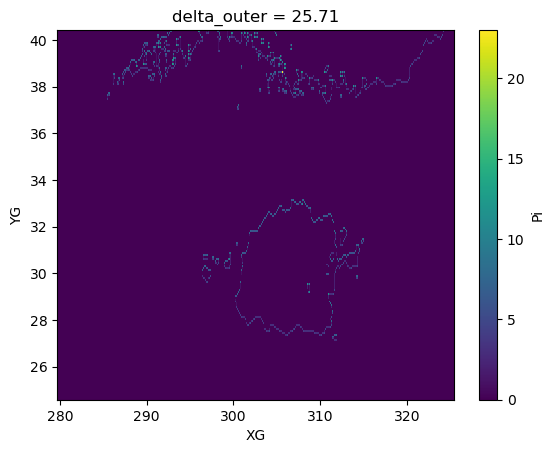

In [31]:
mask_b.isel(delta_outer = 6).plot()

# Volume of control volume

Compute and save the volume of the selected control volume across multiple b-layers. 

In [93]:
# volume of mode water
Svy = 3.15e13 #m^3
Pi_thres = 0.15e-9
year = years[0]
ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,years[0])), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=ntimes[0,1],
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))
    
for itime in ntimes[0]:     
    
    dsz = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zetab/%010d/' 
                           % (year,itime))
                  ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk}) 
    dsm = xr.open_zarr(op.join(savedir,twadir,'run%4d/PV_mask_%2d/%010d/' 
                                                % (year,Pi_thres *1e11,itime)
                              ))
    
    count = 0
    for dd in dsm.delta_outer:
        mask = dsm.mask.sel(delta_outer = dd)
        rA = ds.rA.sel(XC = mask.XG.values, 
                       YC = mask.YG.values, 
                       method = 'nearest')
        dzetab = dsz.dzetab.sel(XC = mask.XG.values,
                                YC = mask.YG.values, 
                                method = 'nearest').sel(delta_outer = dd)
        grid = Grid(dsz.sel(XC = mask.XG.values, XG = mask.XG.values,
                       YC = mask.YG.values, YG = mask.YG.values, 
                       method = 'nearest'),
                    coords={'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
               )

        # compute volume
        mask_vol = xr.where(grid.interp(
                            grid.interp(xr.where(mask !=0, 1, 0), 
                                        'Y'), 
                                            'X') == 1, 1, 0)

        vol_new = rA * dzetab * mask_vol / Svy
        if count == 0:
            vol = vol_new
        else:
            vol = xr.concat([vol,vol_new],dim = 'delta_outer')
        count += 1
        
    dsave = vol.to_dataset(name='volume').chunk({'YC':ychunk,'XC':xchunk})   
        
    dsave.to_zarr(op.join(savedir,twadir,'run%4d/STMW_vol_%2d/%010d/' 
                                            % (year,Pi_thres *1e11,itime)), mode='w')
    dsave.close()
    dsm.close()
    dsz.close()
    print(itime)
ds.close()

1419120
1421280
1423440
1425600
1427760
1429920
1432080
1434240
1436400
1438560
1440720
1442880
1445040
1447200
1449360
1451520
1453680
1455840
1458000
1460160
1462320
1464480
1466640
1468800
1470960
1473120
1475280
1477440
1479600
1481760
1483920
1486080
1488240
1490400
1492560
1494720
1496880
1499040
1501200
1503360
1505520
1507680
1509840
1512000
1514160
1516320
1518480
1520640
1522800
1524960
1527120
1529280
1531440
1533600
1535760
1537920
1540080
1542240
1544400
1546560
1548720
1550880
1553040
1555200
1557360
1559520
1561680
1563840
1566000
1568160
1570320
1572480
1574640


In [94]:
tot_vol_25 = []
tot_vol_15 = []
for itime in ntimes[0]:     
    dsv1 = xr.open_zarr(op.join(savedir,twadir,'run%4d/STMW_vol_25/%010d/' 
                                                % (year,itime)
                              ))
    tot_vol_25 = np.concatenate((tot_vol_25, dsv1.volume.sum().values), axis=None)
    dsv2 = xr.open_zarr(op.join(savedir,twadir,'run%4d/STMW_vol_15/%010d/' 
                                                % (year,itime)
                              ))
    tot_vol_15 = np.concatenate((tot_vol_15, dsv2.volume.sum().values), axis=None)
    

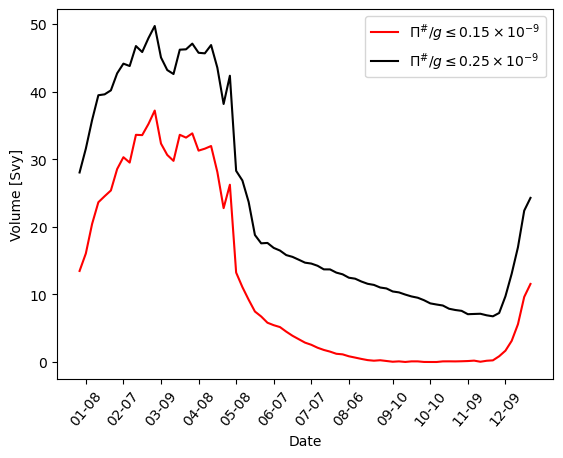

In [101]:
figdir = '/tank/users/lsun/figures/modewater/' # Directory for figures
fig, ax = plt.subplots()
ax.plot(dates,tot_vol_15,'r', label = r'$\Pi^{\#}/g \leq 0.15 \times 10^{-9}$')
ax.plot(dates,tot_vol_25,'k', label = r'$\Pi^{\#}/g \leq 0.25 \times 10^{-9}$')
ax.set_xticks([dates[1], dates[7], dates[13], dates[19], dates[25],
            dates[31], dates[37], dates[43], dates[50], dates[56],
            dates[62], dates[68]])
ax.set_xticklabels(['01-08', '02-07', '03-09', '04-08', '05-08', 
                    '06-07', '07-07', '08-06', '09-10', '10-10',
                    '11-09', '12-09'],
       rotation=50)
ax.set_xlabel('Date')
ax.set_ylabel('Volume [Svy]')
ax.legend()
# plt.savefig(figdir+'Total_volume.eps', format = 'eps', dpi= 600,  -->
            # bbox_inches = 'tight', pad_inches = 0.1)
plt.show() 